Import the necessary libraries and modules.

In [67]:
import pandas as pd
import numpy as np
import csv
import ast
import matplotlib.pyplot as plt
import io

Change the Path variable to point to your CSV file

In [68]:
path = r"C:\Users\joacosta\Work\Beumer\NortFord\Data Analitics\Programs to extract Data\Log Monitor Files\09-20-2025\SO4_From_10-50_To_11-44.csv"

In [69]:
raw_df = pd.read_csv(
    path,
    sep=";",
    header=None,
    engine="python",
    quoting=csv.QUOTE_NONE,
    skipinitialspace=True,
    on_bad_lines="skip",
    dtype=str
)

# Cleaning dataset

In [70]:
df_no_quotation = raw_df.replace('"', '', regex=True)
# Rename original df columns
df_no_quotation.columns = [
    "timeStamp", "flag", "systemName", "ipAddress", "sender", "unkown",
    "unkown_2", "PLCTimeStamp", "machineCode", "unitID", "sequenceNo",
    "rawMessage"
]

df_no_quotation["rawMessage"] = df_no_quotation["rawMessage"].str.removeprefix("->{").str.removesuffix("}<")

def split_key_values(text):
    parts = []
    buf = ""
    inside_brackets = 0
    
    for ch in text:
        if ch == "[":
            inside_brackets += 1
        elif ch == "]":
            inside_brackets -= 1
        
        if ch == "," and inside_brackets == 0:
            parts.append(buf.strip())
            buf = ""
        else:
            buf += ch
    if buf:
        parts.append(buf.strip())
    return parts

def parse_row(text):
    items = split_key_values(text)
    d = {}
    for item in items:
        if ":" in item:
            k, v = item.split(":", 1)
            d[k.strip()] = v.strip()
    return d

df_expanded = df_no_quotation["rawMessage"].apply(parse_row).apply(pd.Series)

# Function to parse array-like strings and return the first element
def first_element(val):
    if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
        try:
            # Try to parse safely into Python list
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except (ValueError, SyntaxError):
            # If literal_eval fails (e.g. strings without quotes like [Used,FromAwcs])
            parts = [x.strip() for x in val.strip("[]").split(",")]
            return parts[0] if parts else val
    return val

# Apply to your target columns
for col in ["requestedDestMCID", "sortCode", "requestedDestStatus"]:
    df_expanded[col] = df_expanded[col].apply(first_element)

# Drop the old structured column
df_temp = df_no_quotation.drop(columns=["rawMessage"])

# Merge with expanded dataframe
df_clean = pd.concat([df_temp, df_expanded], axis=1)

df_clean.head(10)

,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType
0,250920 105104 943,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:32:27,506",MC01,54177,...,0788,S01ab,----------,3002,-1,21,Unused,AwcsConverterMcIf,Send,S04
1,250920 105247 189,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:34:09,752",MC01,54177,...,0789,S01ab,----------,3002,-1,21,Unused,AwcsConverterMcIf,Send,S04
2,250920 105329 428,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:34:51,985",MC01,54177,...,0790,S01ab,----------,3002,-1,21,Unused,AwcsConverterMcIf,Send,S04
3,250920 105404 411,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:26,990",MC01,54177,...,0791,S01aa,SD0004GOOD_001_v,34,34,0,Used,AwcsConverterMcIf,Send,S04
4,250920 105405 849,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:28,426",MC01,54177,...,0792,S01aa,SD0004GOOD_001_v,0,0,0,Used,AwcsConverterMcIf,Send,S04
5,250920 105406 838,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:29,382",MC01,54177,...,0794,S01aa,SD0005GOOD_001_v,2,2,0,Used,AwcsConverterMcIf,Send,S04
6,250920 105408 507,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:31,063",MC01,54177,...,0796,S01aa,SD0008GOOD_001_v,4,4,0,Used,AwcsConverterMcIf,Send,S04
7,250920 105408 965,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:31,543",MC01,54177,...,0793,S01aa,SD0002GOOD_001_v,6,6,0,Used,AwcsConverterMcIf,Send,S04
8,250920 105409 950,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:32,502",MC01,54177,...,0800,S01aa,SD0006GOOD_001_v,8,8,0,Used,AwcsConverterMcIf,Send,S04
9,250920 105410 645,N,SMC,10.158.244.100:7200,AWCS.Comm,,,"22:35:33,223",MC01,54177,...,0795,S01aa,SD0002GOOD_001_v,10,10,0,Used,AwcsConverterMcIf,Send,S04


Removing bad packages that just produce noise in the results

In [71]:
print(df_clean["indexNo"].dtype)

object


In [72]:
# # normalize to clean strings
# df_clean["indexNo"] = df_clean["indexNo"].astype("string").str.strip()

# # IDs to removed
# bad_ids = ["0101", "0204", "0309"]

# # snapshot row numbers before any filtering
# df_pos = df_clean.reset_index(drop=False).rename(columns={"index": "row_number"})

# # rows matching the target IDs
# hits = df_pos[df_pos["indexNo"].isin(bad_ids)].copy()

# # rows (row_number) per ID
# print("Row numbers per indexNo:")
# for k, grp in hits.sort_values(["indexNo", "row_number"]).groupby("indexNo"):
#     print(f"  {k}: {grp['row_number'].tolist()}")

# # counts per ID
# print("\nCounts per ID:")
# print(hits["indexNo"].value_counts())

# # full rows if you want to inspect
# cols_to_show = ["row_number", "indexNo"]
# print("\nMatching rows:")
# print(hits.sort_values(["indexNo", "row_number"])[cols_to_show].to_string(index=False))


In [73]:
# ids to remove (strings, with leading zeros)
bad_ids = ['0007', '0009', '0011', '0012', '0016', '0018', '0058', '0061', '0063', '0071', '0074', '0092', '0100', '0105', '0124', '0156', '0159', '0176', '0183', '0208', '0221', '0223', '0225', '0231', '0235', '0236', '0245', '0249', '0272', '0273', '0391', '0394', '0398', '0401', '0402', '0409', '0420', '0421', '0441', '0446', '0448', '0466', '0485', '0493', '0514', '0518', '0521', '0569', '0616', '0645', '0705', '0723', '0803', '0805', '0806', '0817', '0870', '0886', '0940', '0966', '0968', '0980', '1006', '1009', '1015', '1031', '1045', '1057', '1073', '1076', '1087', '1098', '1132', '1150', '1155', '1169', '1175', '1186', '1197', '1213', '1239', '1258', '1260', '1294', '1324', '1332', '1336', '1348', '1359', '1396', '1415', '1417', '1432', '1436', '1451', '1473', '1493', '1521', '1539', '1583', '1609', '1650', '1687', '1692', '1701', '1707', '1708', '1717', '1750', '1811', '1814', '1820', '1821', '1826', '1842', '1846', '1850', '1853', '1899', '1920', '1956', '1974', '1975', '1980', '1983', '1985', '1986', '1997', '0299', '0411', '0468','0544','1018','1160','0261','0389']
bad_set = set(bad_ids)

# identify matching rows and update reasonCode to 0
mask = df_clean["indexNo"].isin(bad_set)
matched_ids = df_clean.loc[mask, "indexNo"].dropna().unique().tolist()
modified_count = mask.sum()

# set sortCode to 0 for matching rows
df_clean.loc[mask, "sortCode"] = 0

not_found = sorted(list(bad_set.difference(matched_ids)))
print(f"Modified sortCode to 0 for {modified_count} rows by exact string match on indexNo.")
if matched_ids:
    print("IDs modified:", matched_ids)
if not_found:
    print("IDs not found (no rows matched):", not_found)


Modified sortCode to 0 for 624 rows by exact string match on indexNo.
IDs modified: ['0803', '0805', '0806', '0817', '0870', '0886', '0940', '0968', '0966', '0980', '1006', '1018', '1009', '1015', '1031', '1045', '1057', '1076', '1073', '1087', '1098', '1132', '1155', '1150', '1160', '1175', '1169', '1197', '1186', '1213', '1239', '1260', '1258', '1294', '1324', '1336', '1332', '1348', '1359', '1396', '1493', '1417', '1415', '1432', '1436', '1451', '1473', '1521', '1539', '1583', '1609', '1650', '1687', '1692', '1701', '1708', '1707', '1717', '1750', '1811', '1814', '1821', '1820', '1826', '1842', '1846', '1850', '1853', '1899', '1920', '1956', '1974', '1975', '1980', '1986', '1983', '1985', '1997', '0007', '0009', '0012', '0011', '0018', '0016', '0058', '0061', '0063', '0071', '0074', '0092', '0100', '0105', '0124', '0156', '0159', '0183', '0176', '0208', '0223', '0221', '0225', '0235', '0231', '0236', '0245', '0261', '0249', '0273', '0272', '0299', '0389', '0398', '0402', '0409', '03

In [74]:
df_clean.shape

(9822, 24)

In [75]:
df_clean.nunique()

timeStamp              9751
flag                      1
systemName                1
ipAddress                 1
sender                    1
unkown                    1
unkown_2                  1
PLCTimeStamp           9797
machineCode               1
unitID                    1
sequenceNo              256
event                     1
plcRecordNo            1991
itemID                 6715
indexNo                1991
locationAWCS              2
barcodeAWCS              13
actualDestMCID           22
requestedDestMCID        25
sortCode                  7
requestedDestStatus       2
comHost                   1
comMode                   1
telegramType              1
dtype: int64

In [76]:
# Get list of columns with only 1 unique value
cols_to_drop = df_clean.columns[df_clean.nunique() == 1].tolist()

print("Columns to drop:", cols_to_drop)

df_reduced = df_clean.drop(columns=cols_to_drop)

print("Remaining columns:", df_reduced.columns.tolist())
df_reduced.head()


Columns to drop: ['flag', 'systemName', 'ipAddress', 'sender', 'unkown', 'unkown_2', 'machineCode', 'unitID', 'event', 'comHost', 'comMode', 'telegramType']
Remaining columns: ['timeStamp', 'PLCTimeStamp', 'sequenceNo', 'plcRecordNo', 'itemID', 'indexNo', 'locationAWCS', 'barcodeAWCS', 'actualDestMCID', 'requestedDestMCID', 'sortCode', 'requestedDestStatus']


,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus
0,250920 105104 943,"22:32:27,506",SQ 018,0788,16757U,0788,S01ab,----------,3002,-1,21,Unused
1,250920 105247 189,"22:34:09,752",SQ 131,0789,16758U,0789,S01ab,----------,3002,-1,21,Unused
2,250920 105329 428,"22:34:51,985",SQ 011,0790,16759U,0790,S01ab,----------,3002,-1,21,Unused
3,250920 105404 411,"22:35:26,990",SQ 163,0791,16760U,0791,S01aa,SD0004GOOD_001_v,34,34,0,Used
4,250920 105405 849,"22:35:28,426",SQ 246,0792,16761U,0792,S01aa,SD0004GOOD_001_v,0,0,0,Used


In [77]:
# Dictionary for mapping sort codes
sort_code_map = {
    0: "Success",
    1: "Unknown",
    2: "Unexpected_Container",
    3: "Tracking_Error",
    4: "Gap_Error",
    5: "Destination_Full",
    6: "Destination_Non_Operational",
    7: "Invalid_Destination",
    8: "No_Read",
    9: "No_Code",
    10: "Multi_Label",
    11: "<reserved>",
    12: "Destination_Disabled",
    13: "Throughput_Limit",
    14: "Failed_To_Divert",
    15: "<reserved>",
    16: "No_Destination_Received",
    17: "Lost_Container",
    18: "Dimension_Error",
    19: "Weight_Error",
    20: "Container_Utilization",
    21: "Unable_To_Divert",
    22: "Destination_Not_Attempted"
}
# Add a new column for description
df_reduced["sortReason"] = df_reduced["sortCode"].map(sort_code_map)


In [78]:
df_reduced.head()

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus,sortReason
0,250920 105104 943,"22:32:27,506",SQ 018,0788,16757U,0788,S01ab,----------,3002,-1,21,Unused,Unable_To_Divert
1,250920 105247 189,"22:34:09,752",SQ 131,0789,16758U,0789,S01ab,----------,3002,-1,21,Unused,Unable_To_Divert
2,250920 105329 428,"22:34:51,985",SQ 011,0790,16759U,0790,S01ab,----------,3002,-1,21,Unused,Unable_To_Divert
3,250920 105404 411,"22:35:26,990",SQ 163,0791,16760U,0791,S01aa,SD0004GOOD_001_v,34,34,0,Used,Success
4,250920 105405 849,"22:35:28,426",SQ 246,0792,16761U,0792,S01aa,SD0004GOOD_001_v,0,0,0,Used,Success


# Time Window

In [79]:
# Split into parts
parts = df_reduced["timeStamp"].str.split(" ", expand=True)
date_part = parts[0]     # YYMMDD
time_part = parts[1]     # HHMMSS
ms_part   = parts[2]     # milliseconds

# Build datetime string
datetime_str = date_part + time_part + ms_part
df_reduced["parsed_time"] = pd.to_datetime(
    datetime_str,
    format="%y%m%d%H%M%S%f",
    errors="coerce"
)

# filter window
start = pd.to_datetime("2025-09-20 10:51:04.943000")
end   = pd.to_datetime("2025-09-20 11:20:00")

# check limits
data_min = df_reduced["parsed_time"].min()
data_max = df_reduced["parsed_time"].max()

if start < data_min or end > data_max:
    raise ValueError(
        f"Window [{start} → {end}] is outside of data range "
        f"[{data_min} → {data_max}]"
    )

# filter
window_df = df_reduced.loc[
    df_reduced["parsed_time"].between(start, end)
].reset_index(drop=True)




In [80]:
window_df.head(1)

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus,sortReason,parsed_time
0,250920 105104 943,"22:32:27,506",SQ 018,0788,16757U,0788,S01ab,----------,3002,-1,21,Unused,Unable_To_Divert,2025-09-20 10:51:04.943


In [81]:
window_df.tail(10)

,timeStamp,PLCTimeStamp,sequenceNo,plcRecordNo,itemID,indexNo,locationAWCS,barcodeAWCS,actualDestMCID,requestedDestMCID,sortCode,requestedDestStatus,sortReason,parsed_time
5501,250920 111957 282,"23:01:19,847",SQ 088,0509,20461U,0509,S01aa,SD0010GOOD_001_v,32,32,0,Used,Success,2025-09-20 11:19:57.282
5502,250920 111957 549,"23:01:20,114",SQ 096,0287,20239U,0287,S01ab,SD0003GOOD_001_v,159,159,0,Used,Success,2025-09-20 11:19:57.549
5503,250920 111958 000,"23:01:20,563",SQ 115,0503,20455U,0503,S01aa,SD0009GOOD_001_v,34,34,0,Used,Success,2025-09-20 11:19:58.000
5504,250920 111958 244,"23:01:20,805",SQ 124,0203,20155U,0203,S01aa,SD0004GOOD_001_v,18,18,0,Used,Success,2025-09-20 11:19:58.244
5505,250920 111958 491,"23:01:21,047",SQ 140,0510,20462U,0510,S01aa,SD0007GOOD_001_v,0,0,0,Used,Success,2025-09-20 11:19:58.491
5506,250920 111958 725,"23:01:21,289",SQ 152,0517,20469U,0517,S01aa,SD0001GOOD_001_v,4,4,0,Used,Success,2025-09-20 11:19:58.725
5507,250920 111958 773,"23:01:21,335",SQ 159,0565,20517U,0565,S01ab,----------,3002,-1,21,Unused,Unable_To_Divert,2025-09-20 11:19:58.773
5508,250920 111959 203,"23:01:21,768",SQ 176,1887,19840U,1887,S01aa,SD0006GOOD_001_v,24,24,0,Used,Success,2025-09-20 11:19:59.203
5509,250920 111959 683,"23:01:22,246",SQ 199,0508,20460U,0508,S01aa,SD0004GOOD_001_v,8,8,0,Used,Success,2025-09-20 11:19:59.683
5510,250920 111959 918,"23:01:22,484",SQ 210,0513,20465U,0513,S01aa,SD0009GOOD_001_v,10,10,0,Used,Success,2025-09-20 11:19:59.918


In [82]:
# Count items by sortReason
sort_counts = window_df.groupby("sortReason").size().reset_index(name="count")

print(sort_counts)

             sortReason  count
0  Destination_Disabled    924
1      Destination_Full      8
2      Failed_To_Divert      1
3               Success   4517
4      Unable_To_Divert     61


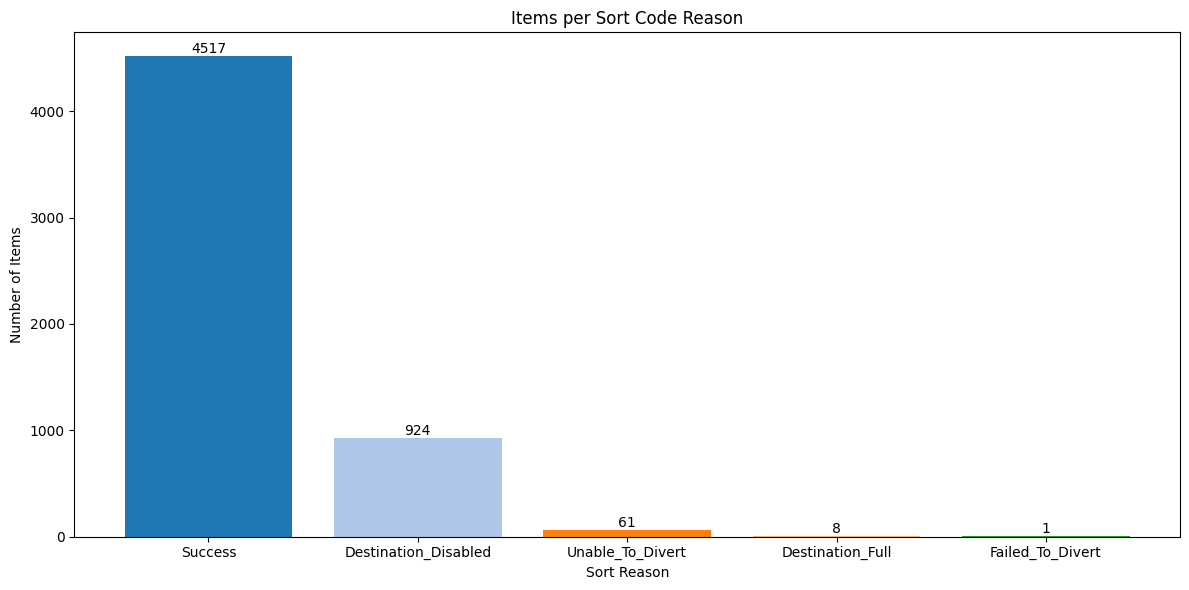

In [83]:
# Sort counts by frequency (optional, looks nicer)
sort_counts = sort_counts.sort_values("count", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(sort_counts["sortReason"], sort_counts["count"], color=plt.cm.tab20.colors) # type: ignore[attr-defined]

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # X position (center of bar)
        height,                            # Y position (just above the bar)
        str(height),                       # Text = count value
        ha="center", va="bottom", fontsize=10
    )

plt.title("Items per Sort Code Reason")
plt.xlabel("Sort Reason")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

# MHE KPIs Analysis

In [84]:
# Map each reason to its category
defect_category_map = {
    # Scan Defect
    "Multi_Label": "Scan Defect",
    "No_Read": "Scan Defect",
    "No_Code": "Scan Defect",

    # MHE Defect
    "Failed_To_Divert": "MHE Defect",
    "Gap_Error": "MHE Defect",
    "Destination_Non_Operational": "MHE Defect",  # Lane_Non_Operational in doc
    "Lost_Container": "MHE Defect",
    "No_Destination_Received": "MHE Defect",
    "Unknown": "MHE Defect",   # Sort_Unknown in doc
    "Tracking_Error": "MHE Defect",
    "Unable_To_Divert": "MHE Defect",
}


In [85]:
# Map defect category
window_df["defectCategory"] = window_df["sortReason"].map(defect_category_map)

# Total packages processed (all rows)
total_processed = len(window_df)

# Count defects only (exclude NaN)
defect_summary = (
    window_df["defectCategory"]
    .value_counts(dropna=True)
    .rename_axis("defectCategory")
    .reset_index(name="count")
)

# Percent over total processed
defect_summary["percentage"] = 100 * defect_summary["count"] / total_processed

# Optional: nicer formatting
defect_summary["percentage"] = defect_summary["percentage"].round(2)

print(defect_summary)


  defectCategory  count  percentage
0     MHE Defect     62        1.13


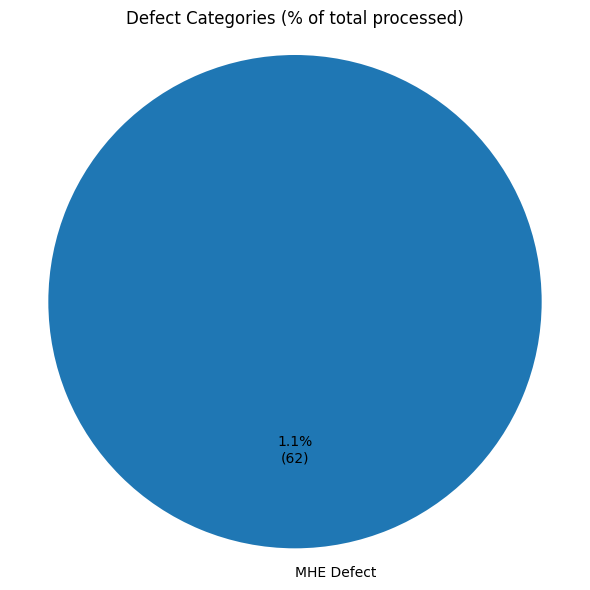

In [86]:
import matplotlib.pyplot as plt

labels = defect_summary["defectCategory"].tolist()
counts = defect_summary["count"].to_numpy()

total_defects = counts.sum()
total_processed = len(window_df)

cmap = plt.get_cmap("tab10")
colors = [cmap(x) for x in np.linspace(0, 1, len(labels))]

def autopct_total(pct_defect_space):
    # recover the absolute count of the wedge
    count = int(round(pct_defect_space * total_defects / 100.0))
    pct_of_total = 100.0 * count / total_processed if total_processed else 0.0
    return f"{pct_of_total:.1f}%\n({count})"

plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=labels,
    autopct=autopct_total,      # labels show % of ALL processed
    startangle=90,
    colors=colors
)
plt.title("Defect Categories (% of total processed)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [87]:
# Filter for sortCode 8 and 10
filtered_df = window_df[window_df['sortCode'].isin([8, 10])]

# Create a new dataset with just the columns we need
export_df = filtered_df[['indexNo', 'timeStamp', 'sortCode']].copy()

# Sort by timeStamp for better organization
export_df = export_df.sort_values('timeStamp')

# Print the results
print(f"Found {len(export_df)} items with sortCode 8 or 10:")
print("\nIndexNo and TimeStamp for sortCode 8 and 10:")
print(export_df.to_string(index=False))

# Export to Excel
output_path = r"C:\Users\joacosta\Dev\Python\ORF5\Data\sortcode_8_10_analysis.xlsx"
export_df.to_excel(output_path, index=False, sheet_name='SortCode_8_10')

print(f"\nData exported to: {output_path}")

# Optional: Show breakdown by sortCode
print(f"\nBreakdown by sortCode:")
print(export_df['sortCode'].value_counts().sort_index())

Found 0 items with sortCode 8 or 10:

IndexNo and TimeStamp for sortCode 8 and 10:
Empty DataFrame
Columns: [indexNo, timeStamp, sortCode]
Index: []

Data exported to: C:\Users\joacosta\Dev\Python\ORF5\Data\sortcode_8_10_analysis.xlsx

Breakdown by sortCode:
Series([], Name: count, dtype: int64)


# Write to excel file

In [88]:
total_processed = len(window_df)

defect_summary = (
    window_df["defectCategory"]
    .value_counts(dropna=True)
    .rename_axis("defectCategory")
    .reset_index(name="count")
)

# % over ALL processed, not just defects
defect_summary["percentage"] = (
    100 * defect_summary["count"] / total_processed
).round(2)

labels = defect_summary["defectCategory"].tolist()
counts = defect_summary["count"].to_numpy()

no_defect_count = max(total_processed - counts.sum(), 0)
labels_all = labels + ["No Defect"]
counts_all = np.append(counts, no_defect_count)

cmap = plt.get_cmap("tab10")
colors = [cmap(x) for x in np.linspace(0, 1, len(labels_all))]

def autopct_if_big(p):
    # write % on wedge only if >= 2% to avoid clutter
    return f"{p:.1f}%" if p >= 2 else ""

fig1, ax1 = plt.subplots(figsize=(8, 6))  # wider to fit legend
wedges, texts, autotexts = ax1.pie(
    counts_all,
    startangle=90,
    colors=colors,
    autopct=autopct_if_big,
    pctdistance=0.75,
    textprops={"fontsize": 10},
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
)

# Donut hole
ax1.add_artist(plt.Circle((0, 0), 0.55, fc="white"))
ax1.set_title("Package Outcomes (Defects vs No Defect)")
ax1.axis("equal")

# Legend on the right
total_all = counts_all.sum()
legend_labels = [
    f"{lbl} — {cnt} ({(cnt/total_all*100):.1f}%)"
    for lbl, cnt in zip(labels_all, counts_all)
]
ax1.legend(
    wedges, legend_labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)
plt.tight_layout()

# Save pie image to buffer for Excel
buf_pie = io.BytesIO()
fig1.savefig(buf_pie, format="png", dpi=150, bbox_inches="tight")
plt.close(fig1)
buf_pie.seek(0)

# =========================================================
# 3) sortReason counts + BAR chart
# =========================================================
sort_counts = (
    window_df["sortReason"]
    .value_counts(dropna=False)  # keep NaNs as their own entry
    .rename_axis("sortReason")
    .reset_index(name="count")
).sort_values("count", ascending=False).reset_index(drop=True)

fig2, ax2 = plt.subplots(figsize=(12, 6))
cmap2 = plt.get_cmap("tab20")
colors2 = [cmap2(i / max(1, len(sort_counts) - 1)) for i in range(len(sort_counts))]

bars = ax2.bar(
    sort_counts["sortReason"].astype(str).tolist(),
    sort_counts["count"].to_numpy(),
    color=colors2
)
for b in bars:
    h = b.get_height()
    ax2.text(b.get_x() + b.get_width()/2, h, str(int(h)), ha="center", va="bottom", fontsize=10)

ax2.set_title("Items per Sort Code Reason")
ax2.set_xlabel("Sort Reason")
ax2.set_ylabel("Number of Items")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save bar image to buffer for Excel
buf_bar = io.BytesIO()
fig2.savefig(buf_bar, format="png", dpi=150, bbox_inches="tight")
plt.close(fig2)
buf_bar.seek(0)

# =========================================================
# 4) Write everything into Excel with generous spacing
# =========================================================
# out_path = "analysis_output.xlsx"
start_str = start.strftime("%Y%m%d-%H%M%S")
end_str   = end.strftime("%Y%m%d-%H%M%S")
out_path = f"SO4_{start_str}_{end_str}.xlsx"


with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    # Analysis_Results (create + header)
    pd.DataFrame().to_excel(writer, sheet_name="Analysis_Results", index=False)
    wb = writer.book
    ws = writer.sheets["Analysis_Results"]
    bold = wb.add_format({"bold": True})  # type: ignore[attr-defined]

    ws.write("A1", "Analysis Summary", bold)
    ws.write("A3", "Total records (window dataset):")
    ws.write_number("B3", len(window_df))

    # Defect summary table
    ws.write("A5", "Defect Category Breakdown (percent over ALL processed)", bold)
    defect_summary.to_excel(writer, sheet_name="Analysis_Results", startrow=6, startcol=0, index=False)
    ws.set_column("A:A", 22)
    ws.set_column("B:B", 12)
    ws.set_column("C:C", 14)

    # Insert PIE at D3 with small offset
    ws.insert_image("D3", "defect_pie.png", {
        "image_data": buf_pie,
        "x_offset": 10, "y_offset": 5,
        # "x_scale": 0.95, "y_scale": 0.95,  # optional
    })

    # Sort table
    start_row_sort = 6 + len(defect_summary) + 3
    ws.write(start_row_sort - 1, 0, "Sort Code Reason Counts", bold)
    sort_counts.to_excel(writer, sheet_name="Analysis_Results", startrow=start_row_sort, startcol=0, index=False)
    ws.set_column("A:A", 30)
    ws.set_column("B:B", 14)

    # Insert BAR far to the right (column L = index 11) with offsets
    ws.insert_image(start_row_sort - 1, 11, "sort_reason_bar.png", {
        "image_data": buf_bar,
        "x_offset": 20, "y_offset": 5,
        # "x_scale": 0.9, "y_scale": 0.9,    # optional
    })

    # Raw/Clean data sheets
    raw_df.to_excel(writer, sheet_name="Raw_Data", index=False)
    window_df.to_excel(writer, sheet_name="Clean_Data", index=False)

print(f"Saved: {out_path}")


Saved: SO4_20250920-105104_20250920-112000.xlsx
